---
title: "ARMA forecasting for non-Gaussian time-series data using Copulas"
author: "Sarem"
date: "2022-06-17"
categories: [Time Series]
format:
  html:
    toc: true
    toc-location: left
    toc-depth: 2
    toc-title: Contents
description-meta: "Yet another ARMA time-series model for non-normal data."
---

## Introduction

ARMA ([AutoRegressive – Moving Average](https://en.wikipedia.org/wiki/Autoregressive%E2%80%93moving-average_model?ref=sarem-seitz.com)) models are arguably the most popular approach to time-series forecasting. Unfortunately, plain ARMA is made for Gaussian distributed data only. On the one hand, you can often still use ARMA by transforming the raw data. On the other hand, this typically makes probabilistic forecasts quite tedious.

One approach to apply ARMA to non-Normal data are Copula models. Roughly, the latter allow us to exchange the Gaussian marginal for any other continuous distribution. At the same time, they preserve the implicit time-dependency between observations that is imposed by ARMA.

If this sounds confusing, I suggest reading the next paragraph carefully. Also, you might want to read some external sources for a deeper understanding, too.

## What are Copulas and how can we use them with ARMA?
Informally, Copulas (or Copulae if you are a Latin hardliner) define joint cumulative distribution functions (c.d.f.) for unit-uniform random variables. Formally, we can describe this as
$$
\begin{gathered}
C\left(u_1, \ldots, u_m\right)=P\left(U_1 \leq u_1, \ldots, U_m \leq u_m\right) \\
U_1, \ldots, U_M \stackrel{\text { i.i.d }}{\sim} \mathcal{U}(0,1)
\end{gathered}
$$
That property alone is quite unspectacular as uniform random variables are not very expressive for practical problems. However, an important result in probability theory will make things more interesting.

The [probability integral transform](http://probability%20integral%20transform/) states that we can transform any continuous random variable to a uniform one by plugging it into its own c.d.f.:

> Let $X$ be continuous with c.d.f. $F_X(x)$, then $F_X(X) \sim \mathcal{U}(0,1)$

We can verify this empirically for a standard Normal example:

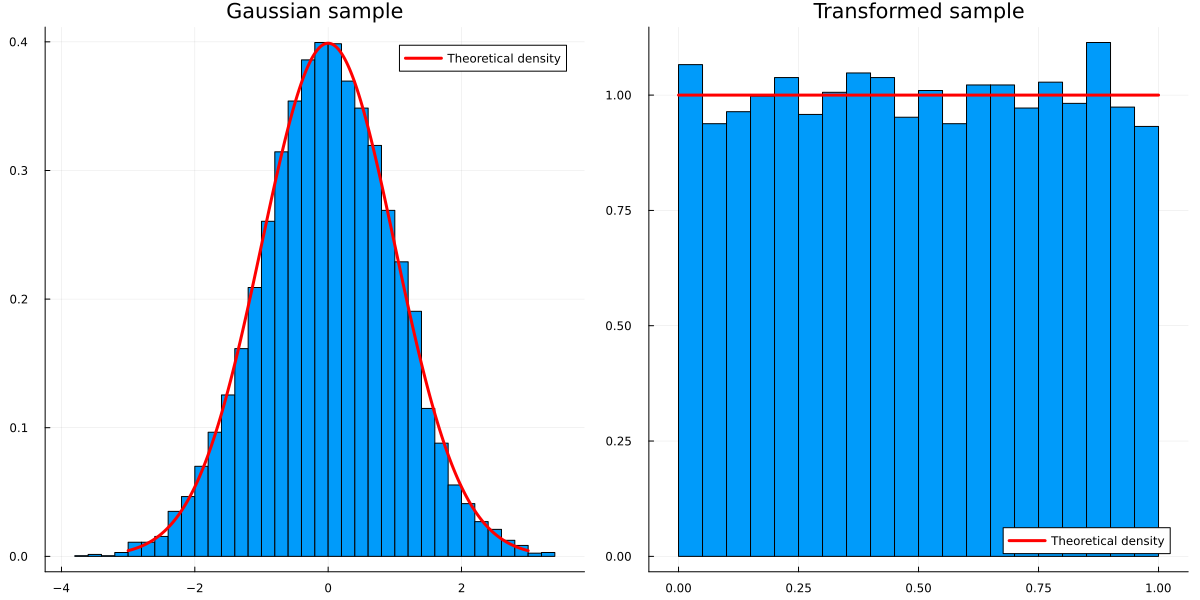

In [1]:
using Distributions, Plots, StatsPlots, Random
Random.seed!(123)

sample = rand(Normal(),10000)
transformed_sample = cdf.(Normal(), sample)

line = collect(-3:0.01:3)
line_transformed = collect(0:0.1:1)

p_sample = histogram(sample,normalize=true, label=:none,title = "Gaussian sample",fmt=:png)
plot!(p_sample, line, pdf.(Normal(),line),color=:red,lw=3,label="Theoretical density",fmt=:png)

p_transformed = histogram(transformed_sample,normalize=true, label=:none,legend=:bottomright,title="Transformed sample",fmt=:png)
plot!(p_transformed, line_transformed, pdf.(Uniform(),line_transformed),color=:red,lw=3,label="Theoretical density",fmt=:png)

plot(p_sample,p_transformed,size=(1200,600),fmt=:png)

As the inverse of a c.d.f. is the quantile function, we can easily invert this transformation. Even cooler, we can transform a uniform random variable to any continuous random variable via
$$
\begin{gathered}
P\left(F_X^{-1}(U) \leq x\right)=F_X(x) \\
F_X^{-1}(\cdot):=\text { inverse (quantile) function of } F_X(\cdot)
\end{gathered}
$$
This inverse transformation will become relevant later on.

### Combining Copulas and the inverse probability transform
In conjunction with Copulas, this allows us to separate the marginal distributions from the dependency structure of joint random variables.

A concrete example: Consider two random variables, $X$ and $Y$ with standard Gamma and Beta marginal distributions, i.e.
$$
X \sim \Gamma(1,1), \quad Y \sim \mathcal{B}(1,1)
$$
With the help of a Copula and the probability integral transform, we can now define a joint c.d.f over both variables such that we preserve their marginal distributions:
$$
P(X \leq x, Y \leq y)=C\left(F_X(x), F_Y(y)\right)
$$

### Introducing the Gaussian Copula
So far, we haven't specified any Copula function yet. A simplistic one is the Gaussian Copula, which is defined as follows:
$$
\begin{gathered}
C_{\text {Gauss }}\left(u_1, \ldots, u_m ; R\right)=\Phi_R\left(\Phi^{-1}\left(u_1\right), \ldots, \Phi^{-1}\left(u_m\right)\right)\\\\
\Phi_R(\cdot, \ldots, \cdot):= \text{Joint c.d.f. of multivariate Gaussian s.t.}\\
\mu=0, \Sigma=R \\
\operatorname{diag}(R)=1\\\\
\Phi^{-1}(\cdot):= \text{Quantile function of standard Gaussian}
\end{gathered}
$$
If we combine this with the Gamma-Beta example from before, we get the following Gaussian Copula joint c.d.f.:
$$
P(X \leq x, Y \leq y)=\Phi_R\left(\Phi^{-1}\left(F_X(x)\right), \Phi^{-1}\left(F_Y(y)\right)\right)
$$
The implicit rationale behind this approach can be described in three steps:

1. Transform the **Gamma and Beta marginals into Uniform marginals** via the respective **c.d.f.s**
2. Transform the **Uniform marginals into standard Normal marginals** via the **quantile functions**
3. Define the **joint distribution via the multivariate Gaussian c.d.f.** with zero mean, unit variance and non-zero covariance (covariance matrix R)

By inverting these steps, we can easily sample from a bi-variate random variable that has the above properties. I.e. standard Gamma/Beta marginals with Gaussian Copula dependencies:

1. Draw a sample from a bi-variate Gaussian with mean zero, unit variance and non-zero covariance (covariance matrix R). You now have **two correlated standard Gaussian variables**.
2. Transform both variables with the standard Gaussian c.d.f. - you now have **two correlated Uniform variables**. (= probability integral transform)
3. Transform these variables with the standard Beta and Gamma quantile functions - you now have **a pair of correlated Gamma-Beta variables**. (= inverse probability integral transform)

Notice that we could drop the zero-mean, unit-variance assumption on the multivariate Gaussian. In that case we would have to adjust the Gaussian c.d.f. to the corresponding marginals in order to keep the integral probability transform valid.

Since we are only interested in the dependency structure (i.e. covariances), standard Gaussian marginals are sufficient and easier to deal with.

Now let us sample some data in Julia:

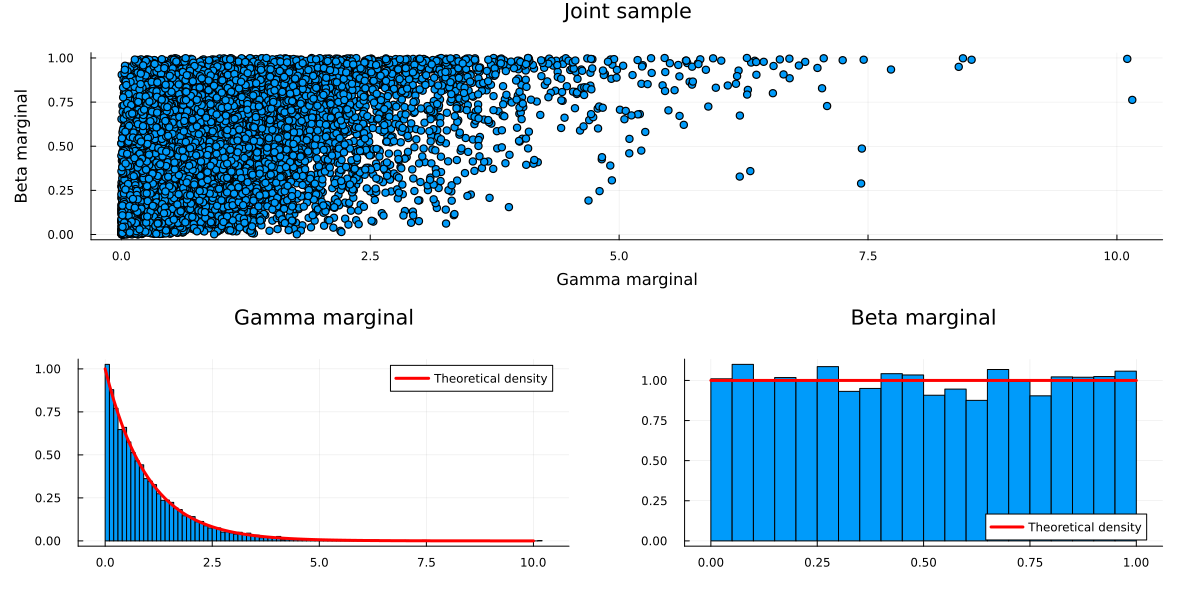

In [5]:
using Measures, Random

Random.seed!(123)

#Step 1: Sample bi-variate Gaussian data with zero mean and unit variance
mu = zeros(2)
R = [1 0.5; 0.5 1]
sample = rand(MvNormal(mu,R),10000)

#Step 2: Transform the data via the standard Gaussian c.d.f.
sample_uniform = cdf.(Normal(), sample)

#Step 3: Transform the uniform marginals via the standard Gamma/Beta quantile functions
sample_transformed = sample_uniform
sample_transformed[1,:] = quantile.(Gamma(),sample_transformed[1,:])
sample_transformed[2,:] = quantile.(Beta(),sample_transformed[2,:])


#Plot the result
scatterplot = scatter(sample_transformed[1,:],sample_transformed[2,:],title="Joint sample",
                      legend=:none,fmt=:png,xlab="Gamma marginal", ylab="Beta marginal")

gamma_line = collect(0:0.1:10)
g_plot = histogram(sample_transformed[1,:],normalize=true, label=:none,title = "Gamma marginal",fmt=:png)
plot!(g_plot, gamma_line, pdf.(Gamma(),gamma_line),color=:red,lw=3,label="Theoretical density",fmt=:png)

beta_line = collect(0:0.01:1)
b_plot = histogram(sample_transformed[2,:],normalize=true, label=:none,legend=:bottomright,title="Beta marginal",fmt=:png)
plot!(b_plot, beta_line, pdf.(Beta(),beta_line),color=:red,lw=3,label="Theoretical density",fmt=:png)


plot(scatterplot,plot(g_plot,b_plot),layout=(2,1),size=(1200,600),fmt=:png,margin=7.5mm)

Congratulations, you have just sampled from your first Copula model!

### But wait - I want to fit a model!
Let's say we observed the above data without the underlying generating process. We only presume that we know that Gamma-Beta marginals and a Gaussian copula are a good choice. How could we fit the model parameters (i.e. 'learn' them in the Machine Learning world)?

As often for statistical models, [Maximum Likelihood](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation?ref=sarem-seitz.com) is a good approach. However, we need a density function for that, so what do we do? We already found out, that a Copula model describes a valid c.d.f. for continuous marginals. Thus, we can derive the corresponding probability density by taking derivatives:
$$
\begin{gathered}
p\left(x_1, \ldots, x_m\right) \\
=\frac{\partial^m}{\partial x_1 \cdots \partial x_m} F\left(x_1, \ldots, x_m\right) \\
=\frac{\partial^m}{\partial x_1 \cdots \partial x_m} C\left(F\left(x_1\right), \ldots, F\left(x_m\right)\right) \\
=c\left(F\left(x_1\right), \ldots, F\left(x_m\right)\right) \cdot \frac{\partial}{\partial x_1} F\left(x_1\right) \cdots \frac{\partial}{\partial x_m} F\left(x_m\right) \\
=c\left(F\left(x_1\right), \ldots, F\left(x_m\right)\right) \cdot p\left(x_1\right) \cdots p\left(x_m\right)
\end{gathered}
$$
(where $c(\cdot, \ldots, \cdot)$ is called a 'Copula density function'; $p(\cdot)$ denotes a probability density function)

Now, for the Gaussian Copula, one can prove the following Copula density function:
$$
c_{\text {Gauss }}\left(u_1, \ldots, u_m ; R\right)=\frac{1}{\sqrt{|R|}} \exp \left(-0.5\left(\begin{array}{c}
\Phi^{-1}\left(u_1\right) \\
\vdots \\
\Phi^{-1}\left(u_m\right)
\end{array}\right)^T \cdot\left(R^{-1}-I\right) \cdot\left(\begin{array}{c}
\Phi^{-1}\left(u_1\right) \\
\vdots \\
\Phi^{-1}\left(u_m\right)
\end{array}\right)\right)
$$

## ARMA with non-normal data via Copulas
Finally, we can return to our initial problem. For this example, we will focus on the stationary ARMA(1,1) model:
$$
\begin{gathered}
y_t=\phi y_{t-1}+\theta \epsilon_{t-1}+\epsilon_t \\
\epsilon_t \sim \mathcal{N}\left(0, \sigma^2\right) \\
|\phi|<1, \quad|\theta|<1
\end{gathered}
$$
For a time-series with $T$ observations, we can derive the unconditional, stationary distribution (see e.g. [here](https://math.stackexchange.com/questions/1265466/the-autocovariance-function-of-arma1-1?ref=sarem-seitz.com)):
$$
\left(\begin{array}{c}
y_1 \\
\vdots \\
y_T
\end{array}\right) \sim \mathcal{N}\left(0, \Sigma=\left[\begin{array}{cccc}
\gamma(0) & \gamma(1) & \cdots & \gamma(T-1) \\
\gamma(1) & \gamma(0) & \cdots & \gamma(T-2) \\
\vdots & \vdots & \ddots & \vdots \\
\gamma(T-1) & \gamma(T-2) & \cdots & \gamma(0)
\end{array}\right]\right)
$$
where $\gamma(h)$ the ARMA $(1,1)$ auto-covariance function for lag $h$ :
$$
\gamma(h)= \begin{cases}\sigma^2\left(1+\frac{(\phi+\theta)^2}{1-\theta^2}\right) & h=0 \\ \sigma^2\left((\phi+\theta) \phi^{h-1}+\frac{(\phi+\theta)^2 \phi^h}{1-\phi^2}\right) & h>0\end{cases}
$$
Informally, the unconditional distribution considers a fixed-length time-series as a single, multivariate random vector. As a consequence, it doesn't matter whether we are sampling from the unconditional distribution or the usual ARMA equations (for an equally long time-series) themselves.

In some instances, such as this one, the unconditional distribution is easier to work with.

Also, notice that the unconditional marginal distributions (the distributions of the y_t's) are the same regardless of the time-lag we are looking at. In fact, we have zero-mean Gaussians with variance equal to the auto-covariance function at zero.

Next, let us define:
$$
\begin{gathered}
G=\frac{1}{\gamma(0)} \cdot I \\
\tilde{\Sigma}=G \Sigma \\
\Rightarrow \operatorname{diag}(\tilde{\Sigma})=1
\end{gathered}
$$
The transformed covariance matrix now implies unit variance while preserving the dependency structure of the unconditional time-series. Literally, we have just derived the **correlation matrix** but let us stick to the idea of a **standardized covariance matrix**.

If we plug this back into a Gaussian copula, we obtain what we could call an ARMA(1,1) Copula. Now, we could use the ARMA(1,1) Copula dependency structure together with any continuous marginal distribution. For example, we could define
$$
\begin{gathered}
p\left(y_t\right)=\operatorname{Exp}\left(y_t \mid 0.5\right) \\
=\frac{1}{0.5} e^{-\frac{y t}{0.5}} \\
y_t>0
\end{gathered}
$$
i.e. the unconditional marginals are Exponential-distributed with rate parameter 0.5. Putting everything together, we obtain the following unconditional density:
$$
p\left(\begin{array}{c}
y_1 \\
\vdots \\
y_T
\end{array}\right)=\prod_{t=1}^T \operatorname{Exp}\left(y_t \mid 0.5\right) \cdot c_{\text {Gauss }}\left(F_{\operatorname{Exp}(0.5)}\left(y_1\right), \ldots, F_{\operatorname{Exp}(0.5)}\left(y_T\right) ; G \Sigma G\right)
$$
Let us combine everything so far and plot an example:

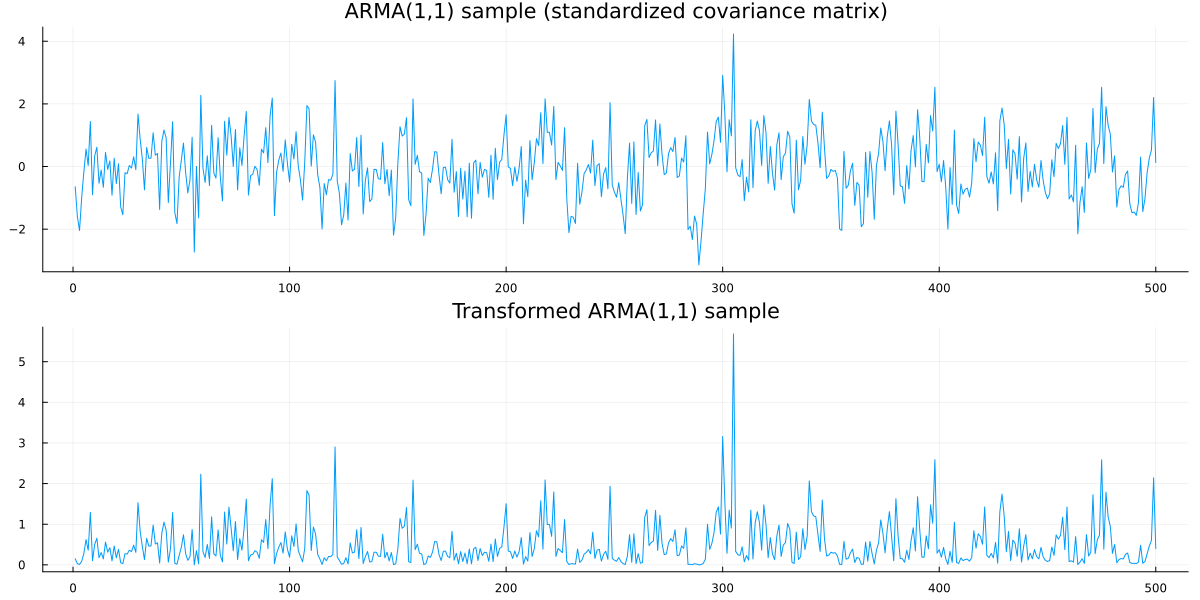

In [6]:
using LinearAlgebra

struct ARMA_1_1
    
    phi
    theta
    sigma
    
end
Broadcast.broadcastable(m::ARMA_1_1) = (m,)


function construct_autocovariance_matrix(m::ARMA_1_1,T=100)    
    autocovariance_matrix = get_autocovariance.(m, construct_time_matrix(T))
    return autocovariance_matrix
end


function construct_time_matrix(T)
    times = collect(0:T-1)
    
    time_matrix = zeros(T,T)
    
    for t in 1:T
        time_matrix[t,1:t-1] = reverse(times[2:t])
        time_matrix[t,t:T] = times[1:T-t+1] 
    end
    
    return time_matrix
end


function get_autocovariance(m::ARMA_1_1,h)        
    if h == 0
        return m.sigma^2 * (1 + (m.phi + m.theta)^2 / (1 - m.phi^2))
    else
        return m.sigma^2 * ((m.phi + m.theta)*m.phi^(h-1) + (m.phi + m.theta)^2*m.phi^h / (1 - m.phi^2))
    end
end


function normalize_covariance(Sigma)
    G = Diagonal(1 ./ diag(Sigma))
    return G*Sigma
end
#-------------------------

Random.seed!(123)
T = 500

arma_model = ARMA_1_1(0.75,-0.5,1)
Sigma = construct_autocovariance_matrix(arma_model,T)
Sigma_tilde = normalize_covariance(Sigma)

unconditional = MvNormal(zeros(T),Sigma_tilde)

arma_sample = rand(unconditional)


exp_target = Exponential(0.5)
exp_sample = quantile.(exp_target, cdf.(Normal(),arma_sample))



arma_plot = plot(arma_sample,legend=:none,title = "ARMA(1,1) sample (standardized covariance matrix)",fmt=:png)

exp_plot = plot(exp_sample,legend=:none,title = "Transformed ARMA(1,1) sample")


plot(
    arma_plot,
    exp_plot,
    layout = (2,1),
    size=(1200,600),
    fmt=:png
)

Clearly, the samples from the Copula model are not Gaussian anymore. In fact, we observe a single draw from a ARMA(1,1) Copula with Exponential-distributed marginals.

## Parameter estimation with Maximum Likelihood
So far, we have only been able to simulate a time-series from the ARMA(1,1) Copula model. In order to fit the model, we will apply Maximum Likelihood. When using Copulas for cross-sectional data, it is usually possible to separate fitting the marginal distributions from fitting the Copula. Unfortunately, this does not work here.

As we only observe one realization of the process per marginal, fitting a distribution based on the marginals alone is impossible. Rather, we now need to optimize both the marginals and the copula at once. This begs the additional difficulty of having to deal with the marginal's parameters inside the marginal's c.d.f..

Namely, our Maximum likelihood objective looks as follows:
$$
=\max _{\phi, \theta, \sigma, \lambda} \log c\left(F_\lambda\left(y_1\right), \ldots, F_\lambda\left(x_m\right) ; R(\phi, \theta, \sigma)\right)+\sum_{t=1}^T \log p_\lambda\left(y_t\right)
$$
where
- $R(\phi, \theta, \sigma):=$ Standardized Gaussian Copula covariance matrix (with respect to the ARMA parameters)
- $F_\lambda(\cdot):=$ c.d.f. of an Exponential distribution with paramater 
- $\lambda$ $p_\lambda(\cdot):=$ probability density of an Exponential distribution with parameter $\lambda$

Optimizing this can become quite ugly as derivatives with respect to a c.d.f.'s parameters are usually fairly complex. Luckily, the Exponential distribution is quite simple and respective derivatives are easily found. Even better, the [Optim.jl](https://julianlsolvers.github.io/Optim.jl/stable/?ref=sarem-seitz.com) package can optimize our log-likelihood via [finite differences](https://en.wikipedia.org/wiki/Finite_difference?ref=sarem-seitz.com) without requiring any derivatives at all.

If we chose another distribution than the Exponential, finite differences might not suffice. In that case, we would have to either implement the c.d.f. derivatives by hand or hope that [ChainRules.jl](https://juliadiff.org/ChainRulesCore.jl/stable/?ref=sarem-seitz.com) can handle them for us.

Also, we transform our model parameters to the correct domains via exp and tanh instead of applying Box constraints in the Optim optimizer. This worked reasonably accurate and fast here:

In [7]:
using Optim

function gauss_copula_ll(R,y)
    n = size(R,2)
    yt = transpose(y)
    R_stab = R .+ Diagonal(ones(n).*1e-6)
    
    return -0.5 * log(det(R_stab))  -0.5*(yt*(inv(R).-Diagonal(ones(n)))*transpose(yt))[1]
end


function likelihood_loss(params)
    
    y_uniform = cdf.(Exponential(exp(params[1])),exp_sample)
    
    model = ARMA_1_1(tanh(params[2]),tanh(params[3]),exp(params[4]))
    
    autocov = construct_autocovariance_matrix(model,length(exp_sample))
    normalized_autocov = Matrix(Hermitian(normalize_covariance(autocov)))
    y_normal = quantile.(Normal(), y_uniform)
        
    loss = -gauss_copula_ll(normalized_autocov,y_normal) - sum(logpdf.(Exponential(exp(params[1])),exp_sample))
    return loss
end

res = optimize(likelihood_loss,[0.,0.,0.,-1],LBFGS())

 * Status: success (objective increased between iterations)

 * Candidate solution
    Final objective value:     1.180344e+02

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 2.73e-10 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.73e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.14e-13 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.63e-16 ≰ 0.0e+00
    |g(x)|                 = 8.21e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   58  (vs limit Inf)
    Iterations:    13
    f(x) calls:    40
    ∇f(x) calls:   40


Now, let us evaluate the result. For the Exponential distribution, the estimated parameter should be close to the true parameter. Regarding the latent ARMA parameters, we primarily need the estimated auto-covariance to be close to ground-truth. This is indeed the case here:

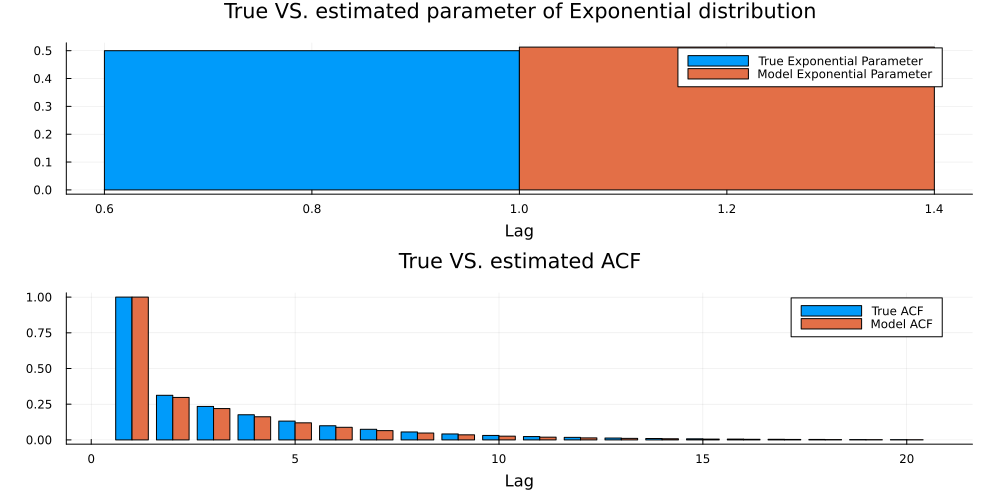

In [8]:
lambda = exp(res.minimizer[1])
phi = tanh(res.minimizer[2])
theta = tanh(res.minimizer[3])
sigma = exp(res.minimizer[4])

estimated_marginal = Exponential(lambda)
estimated_arma_model = ARMA_1_1(phi,theta,sigma) 

true_acf = normalize_covariance(construct_autocovariance_matrix(arma_model,20))[1,:]
model_acf = normalize_covariance(construct_autocovariance_matrix(estimated_arma_model,20))[1,:]


lambda_plot = groupedbar([[0.5] [lambda]],labels=["True Exponential Parameter" "Model Exponential Parameter"]
            ,xlab="Lag",title="True VS. estimated parameter of Exponential distribution",
            fmt=:png,size=(1000,500), margin=5mm)

acf_plot = groupedbar([true_acf model_acf],labels=["True ACF" "Model ACF"],xlab="Lag",title="True VS. estimated ACF",
            fmt=:png,size=(1000,500), margin=5mm)

plot(lambda_plot,acf_plot,layout=(2,1))

## Forecasting with the Copula model
Finally, we want to use our model to produce actual forecasts. Due to the Copula construction, we can derive the conditional forecast density in closed form. As we will see however, mean and quantile forecasts need to be calculated numerically.

First, recall how the Copula model defines a joint density over all 'training'-observations:
$$
p\left(y_1, \ldots, y_T\right)=c\left(F\left(y_1\right), \ldots, F\left(y_T\right)\right) \cdot p\left(y_1\right) \cdots p\left(y_T\right)
$$
In order to forecast a conditional density at h steps ahead, we simply need to follow standard probability laws:
$$
\begin{gathered}
p\left(y_{T+h} \mid y_1, \ldots, y_T\right) \\
=\frac{p\left(y_{T+h}, y_1, \ldots, y_T\right)}{p\left(y_1, \ldots, y_T\right)} \\
=\frac{c\left(F\left(y_{T+h}\right), F\left(y_1\right), \ldots, F\left(y_T\right)\right) \cdot p\left(y_{T+h}\right) \cdot p\left(y_1\right) \cdots p\left(y_T\right)}{c\left(F\left(y_1\right), \ldots, F\left(y_T\right)\right) \cdot p\left(y_1\right) \cdots p\left(y_T\right)} \\
=\frac{c\left(F\left(y_{T+h}\right), F\left(y_1\right), \ldots, F\left(y_T\right)\right)}{c\left(F\left(y_1\right), \ldots, F\left(y_T\right)\right)} \cdot p\left(y_{T+h}\right)
\end{gathered}
$$
This boils down to the ratio of two Copula evaluations times the marginal density evaluated at the target point. However, we still need to find a way to use this equation to calculate a mean forecast and a forecast interval.

As the density is arguably fairly complex, we won't even try to derive any of these values in closed form. Rather, we use numerical methods to find the target quantities.

For the mean, we simply use quadrature to approximate the usual integral
$$
\mathbb{E}\left[y_{T+h} \mid y_1, \ldots, y_T\right] \approx \int_0^U y_{T+h} \cdot p\left(y_{T+h} \mid y_1, \ldots, y_T\right) d y_{T+h}
$$
with U a sufficiently large value to capture most of the probability mass (approximation up to infinity is obviously not possible).

For the forecast interval, we use the 90% prediction interval. Thus, we need to find the 5% and the 95% quantiles of the conditional density. This can be done via another approximation, this time through an Ordinary Differential Equation:
$$
\frac{d F^{-1}}{d u}=\frac{1}{p\left(F^{-1}(u) \mid y_1, \ldots, y_T\right)}
$$
with $F^{-1}(u)$ the quantile function corresponding to $p\left(y_{T+h} \mid y_1, \ldots, y_T\right)$ evaluated at $u \in[0.0,1.0]$

For a derivation of this formula, see, for example, [here](https://blogs.sas.com/content/iml/2022/04/06/differential-equation-quantiles.html?ref=sarem-seitz.com#:~:text=Appendix%3A%20Derive%20the%20quantile%20ODE). Integrating the ODE from zero up to the target quantile yields the respective target quantile value. The latter can be done numerically via [DifferentialEquations.jl](https://diffeq.sciml.ai/stable/tutorials/ode_example/?ref=sarem-seitz.com).

With this, we can finally calculate the forecast and plot the result:

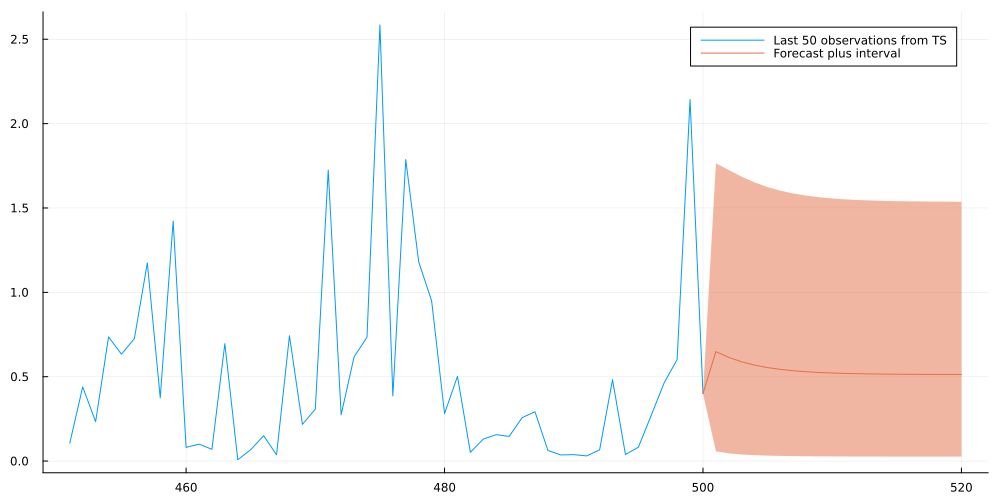

In [11]:
using QuadGK
using DifferentialEquations


#precompute autocovariance matrix to save some computation time
T = 500+20
autocovariance = construct_autocovariance_matrix(estimated_arma_model, T)
normalized_autocov = normalize_covariance(autocovariance) 

#this yields the conditional density for any ARMA, any Exponential marginal and at any 'h' in the future
function evaluate_conditional_density_forecast(x, model::ARMA_1_1, marginal::Distributions.Exponential, y, t_forecast=1)
    T_train = length(y)

    target_cov = normalized_autocov[vcat(collect(1:T_train),T_train+t_forecast),vcat(collect(1:T_train),T_train+t_forecast)]
    
    y_normal = quantile.(Normal(),cdf.(marginal,y))
    x_normal = quantile(Normal(),cdf(marginal,x))
    
    copula_density_train = exp(gauss_copula_ll(target_cov[1:T_train,1:T_train],y_normal))
    copula_density_full = exp(gauss_copula_ll(target_cov,vcat(y_normal,x_normal)))
    marginal_density = pdf(marginal,x)
    
    return marginal_density * copula_density_full/copula_density_train     
end

#conditional density at forecast period 't'
p(x,t) = evaluate_conditional_density_forecast(x,estimated_arma_model,estimated_marginal,exp_sample,t)

#mean forecast uses Quadrature to approximate the intractable 'mean'-integral
mean_forecast = [quadgk(x->p(x,t)*x, 0, quantile(estimated_marginal, 1 - 1e-6), rtol=1e-4)[1] for t in 1:20]

#quantile forecast via differential equation: 
#homepages.ucl.ac.uk/~ucahwts/lgsnotes/EJAM_Quantiles.pdf
function approximate_quantile(q, t=1)

    target_density(x) = p(x,t)
    diffeq(u,p,t) = 1/target_density(u)
    
    u0=1e-6
    tspan=(0.0,q)

    prob = ODEProblem(diffeq,u0,tspan)
    sol = solve(prob,Tsit5(),reltol=1e-4,abstol=1e-4)
    
    return sol.u[end]
end

#10% prediction/forecast interval
lower_05 = [approximate_quantile(0.05,t) for t in 1:20]
upper_95 = [approximate_quantile(0.95,t) for t in 1:20]


#plot the final result
ribbon_lower = vcat(exp_sample[end],mean_forecast) .- vcat(exp_sample[end],lower_05)
ribbon_upper =  vcat(exp_sample[end],upper_95) .- vcat(exp_sample[end],mean_forecast) 

plot(collect(1:500)[end-49:end],exp_sample[end-49:end],fmt=:png,size=(1000,500),label="Last 50 observations from TS")
plot!(collect(500:520),vcat(exp_sample[end],mean_forecast),ribbon=(ribbon_lower,ribbon_upper),fmt=:png, label="Forecast plus interval")

This looks indeed quite reasonable and the forecast appears to converge to a stable distribution as we predict further ahead into the future.

## Conclusion
As we have seen, Copulas make it possible to extend well-known models to non-Gaussian data. This allowed us to transfer the simplicity of the ARMA model to Exponential marginals that were only defined for positive values.

One complication arises when the size of the observed time-series becomes very large. In that case, the unconditional covariance matrix will scale poorly and the model fitting step will likely become impossible.

Then, we need to find a computationally more efficient solution. One possible approach are [Implicit Copulas](https://arxiv.org/pdf/2109.04718.pdf?ref=sarem-seitz.com) which define a Copula density through a chain of conditional densities.

Of course, there are many other ways to integrate Copulas into classical statistical and Machine Learning models. For the latter, research is still a little sparse. However, I strongly believe that there is at least some potential for a modern application of these classic statistical objects.

## References
**[1]** Hamilton, James Douglas. Time series analysis. Princeton university press, 2020.

**[2]** Nelsen, Roger B. An introduction to copulas. Springer Science & Business Media, 2007.

**[3]** Smith, Michael Stanley. Implicit copulas: An overview. Econometrics and Statistics, 2021.